White Background detection

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
import glob
import torch.nn.functional as F
import torch.nn as nn
from matplotlib import cm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from IPython.display import clear_output
import math

In [ ]:
plt.plot()

In [2]:
num = 3000
image_size = 128
total_files = 64467
current_perc = 0

im_list = []
i = 0

for filename in glob.glob('Data/Cars/*.jpg'):
    image=Image.open(filename)
    im_list.append(np.array(image))
    if math.floor(i/total_files*100) > current_perc:
        current_perc += 1
        s = '[' + '-'*current_perc + str(current_perc+1) + '%' + ' '*(99-current_perc)+ ']'
        print('       ----------------------------------------Loading Data----------------------------------------', '\n', s)
        clear_output(wait=True)
        
        
    i += 1
    #if i >= num: break

KeyboardInterrupt: 

In [11]:
def get_white_background_ids(images):
    
    ids = []
    brk = False
    current_percent = 0
    for idx, im in enumerate(im_list):
        bgw = True
        for j in range(im.shape[1]):
            if((im[0,j,0] != 255) or (im[0,j,1] != 255) or (im[0,j,2] != 255)):
                bgw = False
                break
            if((im[im.shape[0] - 1,j,0] != 255) or (im[im.shape[0] - 1,j,1] != 255) or (im[im.shape[0] - 1,j,2] != 255)):
                bgw = False
                break
        if(bgw): ids.append(idx)
        if(math.floor(idx/len(im_list)*100) > current_percent):
            current_percent += 1
            s = '[' + '-'*current_percent + str(current_percent+1) + '%' + ' '*(99-current_percent)+ ']'
            print('  ----------------------------------------Checking Backgrounds----------------------------------------', '\n', s)
            clear_output(wait=True)
    return ids 

In [12]:
ids = get_white_background_ids(im_list)

 ----------------------------------------Checking Backgrounds---------------------------------------- 
 [---------------------------------------------------------------------------------------------------100%]


In [13]:
print(len(ids))

19922


In [143]:
i = 0

for filename in glob.glob('Data/Cars/*.jpg'):
    if(i in ids):
        image=Image.open(filename)
        #image.save('Data/No_background' +filename[9:]) uncomment to generate data in the folder
    i += 1

Bodywork color detection

In [2]:
from sklearn.cluster import KMeans

In [3]:
num = 3000
image_size = 128
total_files =19922
current_perc = 0

im_list = []
i = 0

for filename in glob.glob('Data/No_background/*.jpg'):
    image=Image.open(filename)
    im_list.append(np.array(image))
    if math.floor(i/total_files*100) > current_perc:
        current_perc += 1
        s = '[' + '-'*current_perc + str(current_perc+1) + '%' + ' '*(99-current_perc)+ ']'
        print('       ----------------------------------------Loading Data----------------------------------------', '\n', s)
        clear_output(wait=True)
        
        
    i += 1
    #if i >= num: break

       ----------------------------------------Loading Data---------------------------------------- 
 [---------------------------------------------------------------------------------------------------100%]


In [4]:
def get_car_color(image):
    clt = KMeans(n_clusters = 3)
    clt.fit(image)
    c = clt.cluster_centers_
    return c, clt.labels_

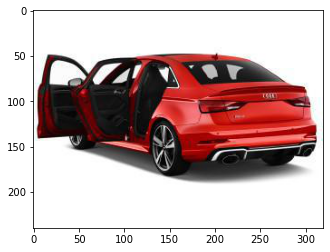

In [6]:
i = 547

im = im_list[i].reshape(-1,3)

plt.imshow(im_list[i])

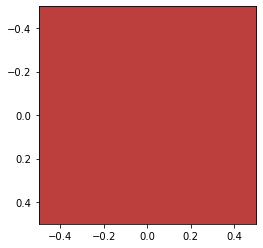

In [7]:
col, lab = get_car_color(im)
plt.imshow(col[np.argsort(np.bincount(lab))[0]].reshape(1,1,3)/255)

In [15]:
def mapping(image):
    return np.sum(image, axis = 2) < 254*3  

In [16]:
def get_bodywork(image, rg):
    M,N = image.shape
    mat = np.zeros((M+6,N+6))
    mat[3:M+3,3:N+3] = image
    mats = []
    for i in range(7):
        for j in range(7):
            mats.append(mat[i:M+i,j:N+j])
    res = mats[0]
    for i in range(1,49):
        res =  np.multiply(res,mats[i])
    return np.multiply(image, res != 0)

In [17]:
def remove_shadow(ima):
    image = ima.copy()
    M, N = image.shape
    row = 0
    
    for i in range(M-1,0,-1):
        line = image[i,:]
        if((line == 1).any()):
            row = i
            break
    image[row-30:row+1] = 0
    return image

In [18]:
def to_data(acc):
    mask = np.sum(acc, axis = 2) < 254*3 
    return acc[mask]

In [19]:
def get_car_color2(image, nc):
    clt = KMeans(n_clusters = nc)
    clt.fit(image)
    c = clt.cluster_centers_
    return c, clt.labels_

In [20]:
import cv2
import time

def color(i, rg, nc, verboseMode = False, plotMode = False):
    
    if(verboseMode):
        start_tot = time.time()
        start = time.time()

    img = im_list[i]

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)

    edges = cv2.Canny(image=img_blur, threshold1=0, threshold2=400)
    
    if(verboseMode):
        stop = time.time()
        print(f"edges: {round(stop-start,3)}s")
        start = time.time()

    ma = (np.abs(1 - edges/255)*mapping(img)).astype(int)

    if(verboseMode):
        stop = time.time()
        print(f"mapping: {round(stop-start,3)}s")
        start = time.time()

    bd = remove_shadow(get_bodywork(ma, rg)) #rg= 3 ou 4 ?

    if(verboseMode):
        stop = time.time()
        print(f"bodywork: {round(stop-start,3)}s")
        start = time.time()
        
    acc_pixels = np.copy(img)
    
    mask = bd == 0
    acc_pixels[mask] = [255,255,255]

    if(verboseMode):
        stop = time.time()
        print(f"acc_pixels: {round(stop-start,3)}s")
        start = time.time()

    data = to_data(acc_pixels)
    
    colors, lab = get_car_color2(data, nc)
    
    colors = colors/255
    thresh_black = 0.4
    thresh_light = 0.2
    dist1 = np.linalg.norm(np.array([0,0,0]) - colors[0])
    dist2 = np.linalg.norm(np.array([0,0,0]) - colors[1])
    if(verboseMode): print(colors)
    if(verboseMode): print(dist1, dist2)
    if((dist1 <= thresh_black) and (dist2 <= thresh_black)):
        color_picked = colors[np.argmax(np.bincount(lab))].reshape(1,1,3)
    elif((dist1 <= thresh_black) or (dist2 <= thresh_black)):
        idlight = np.argmax(np.array([dist1, dist2]))
        idblack = np.argmin(np.array([dist1, dist2]))
        perc = np.bincount(lab)/sum(np.bincount(lab))
        if(verboseMode): print(perc)
        if(perc[idlight] >= thresh_light):
            color_picked = colors[idlight].reshape(1,1,3)
        else:
            color_picked = colors[idblack].reshape(1,1,3)
            
    else:
        color_picked = colors[np.argmax(np.bincount(lab))].reshape(1,1,3)

    if(verboseMode):
        stop = time.time()
        print(f"color: {round(stop-start,3)}s")
        print(f"total: {round(time.time() - start_tot,3)}s")
    
    if(plotMode):
        width=5
        height=5
        rows = 3
        cols = 2
        axes=[]
        fig=plt.figure(figsize = (10,10))

        pic = [img,edges,ma,bd,acc_pixels,color_picked]

        for a in range(rows*cols):
            b = pic[a]
            axes.append( fig.add_subplot(rows, cols, a+1) )
            plt.imshow(b)
        fig.tight_layout()    
        plt.show()
    return color_picked

Problème: 508 547 446, portières ouvertes donne noir aussi reflets sur carosserie

edges: 0.0s
mapping: 0.002s
bodywork: 0.003s
acc_pixels: 0.001s
[[0.27635083 0.09846213 0.06409044]
 [0.95779419 0.78597673 0.76051024]]
0.30028679441210687 1.4537898633832418
[0.90143982 0.09856018]
color: 0.04s
total: 0.046s


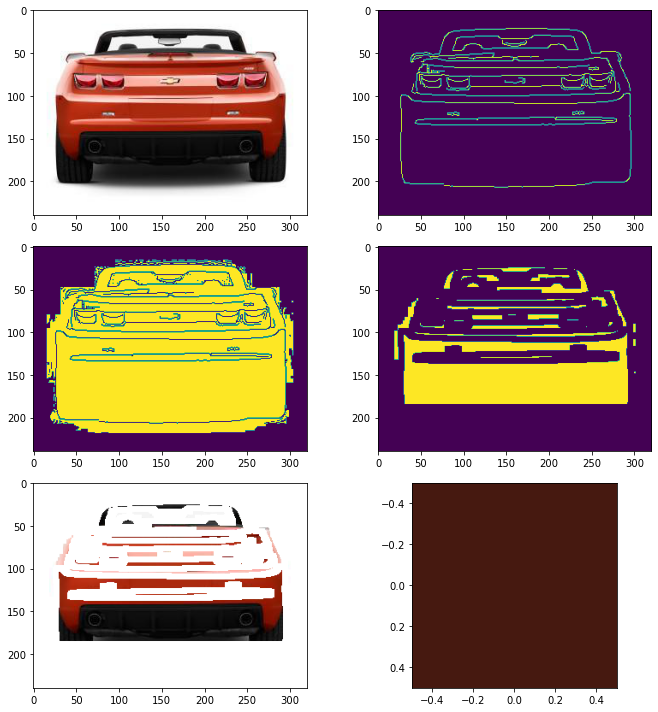

array([[[0.27635083, 0.09846213, 0.06409044]]])

In [32]:
color(3597, 4, 2,verboseMode = True, plotMode = True)

Calculating colors for all images

In [22]:
colors = []
PATH = 'Data/colors'

for i in range(len(im_list)):
    print(i)
    colors.append(color(i,4,2))
    clear_output(wait=True)

76


KeyboardInterrupt: 

In [622]:
PATH = 'Data/colors.npy'

np.save(PATH, np.vstack(colors).reshape(np.vstack(colors).shape[0],3))
colors = np.load(PATH)
print(colors.shape)

(248, 3)


[10574  6379  3002  9677 10673  4732 12961  1247 18106  8567  7733  7994
  8597 11118  6892 15314  3069  3333  3915  7037]


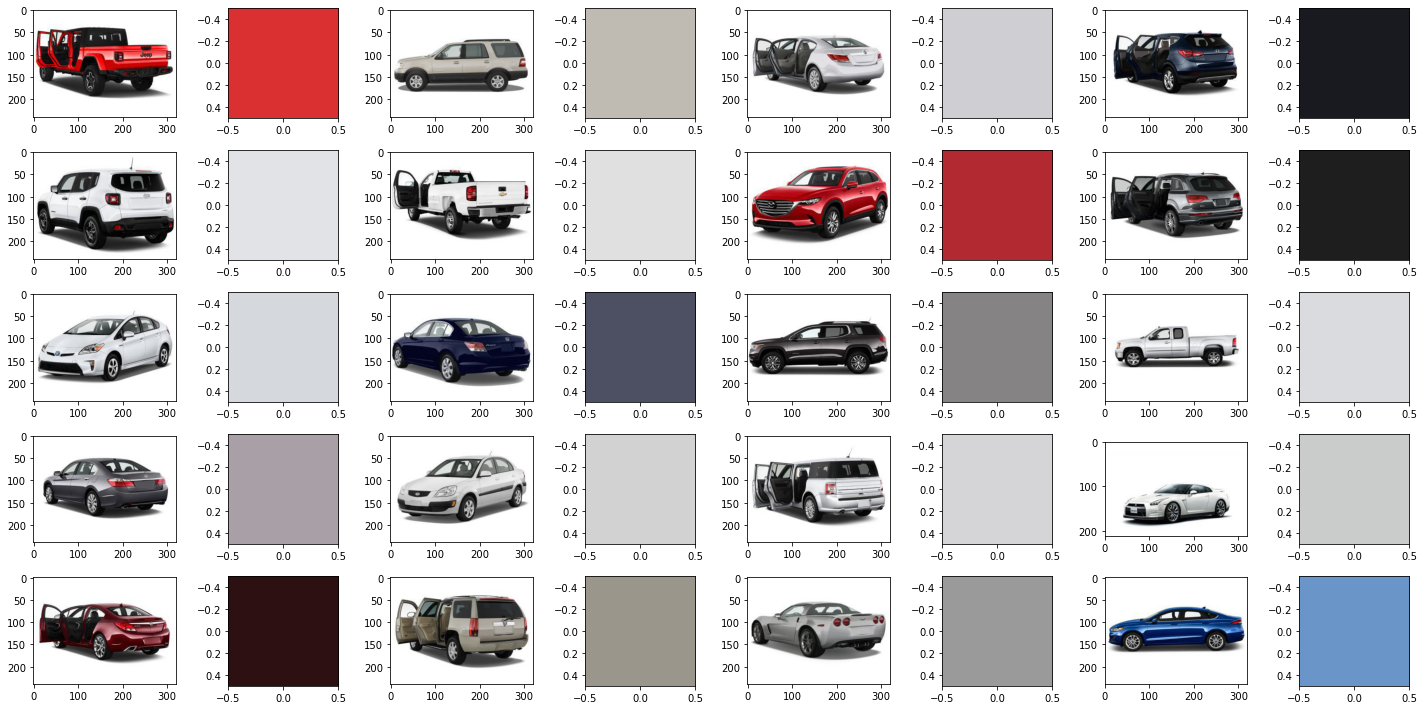

In [210]:
PATH = 'Data/colorsv3.npy'
colors = np.load(PATH)

nb = 20

ids = np.random.choice(np.arange(0,len(im_list),1),nb)
print(ids)

rows = int(nb/4)
cols = 8
axes=[]
fig=plt.figure(figsize = (5*cols/2,nb/2))

pic = []
for i in ids:
    img = im_list[i]
    color_picked = colors[i].reshape(1,1,3)
    pic.append(img)
    pic.append(color_picked)

for a in range(rows*cols):
    b = pic[a]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(b)
fig.tight_layout()    
plt.show()

### Building regressor for color prediction

In [40]:
print(len(im_list))

PATH = 'Data/colorsv3.npy'
colors = np.load(PATH)

print(colors.shape)

19921
(19921, 3)


In [148]:
imagesTens = []
labelsTens = []
image_size = 128

for i in range(len(im_list)):
    
    lengths = im_list[i].shape
    gap = np.abs(lengths[0] - lengths[1])
    argm = np.argmax(lengths)
    if argm == 0:
        pads = [int(gap/2),0,int(gap/2),0]
    else:
        pads = [0,int(gap/2),0,int(gap/2)]
    
    
    transform=T.Compose([
        T.ToPILImage(),
        T.Pad(pads, fill = 255),
        T.Resize(image_size),
        T.ToTensor()])
    
    imagesTens.append(torch.FloatTensor(transform(im_list[i])))
    labelsTens.append(torch.FloatTensor(colors[i]))
    
    
    print(i)
    clear_output(wait=True)

imagesTens = torch.stack(imagesTens)
labelsTens = torch.stack(labelsTens)

19920


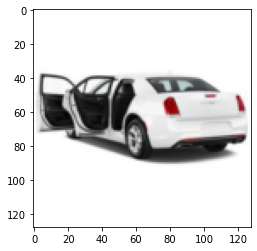

In [153]:
plt.imshow(imagesTens[5465].permute(1,2,0))

In [154]:
print(images.shape)

torch.Size([19921, 3, 128, 128])


In [155]:
nb_images = imagesTens.shape[0]
nb_im_train = int(nb_images*.8)

ids = np.arange(nb_images)
train_ids = np.random.choice(ids, nb_im_train, replace = False)
test_ids = np.array([i for i in ids if i not in train_ids])

In [156]:
print(f"ids: {ids.shape[0]} \ntrain_ids: {train_ids.shape[0]} \ntest_ids: {test_ids.shape[0]}")

ids: 19921 
train_ids: 15936 
test_ids: 3985


In [157]:
class Train_Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self):
        'Initialization'

    def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return train_ids.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        idx = train_ids[index]
        X = imagesTens[index]
        y = labelsTens[index]

        return X, y

In [158]:
batch_size = 64

dl = Train_Dataset()
train_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(train_loader))
print(test[0].shape)

torch.Size([64, 3, 128, 128])


In [159]:
class Test_Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self):
        'Initialization'

    def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return test_ids.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        idx = test_ids[index]
        X = imagesTens[index]
        y = labelsTens[index]

        return X, y

In [160]:
batch_size = 256

dl = Test_Dataset()
test_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(test_loader))
print(test[0].shape)

torch.Size([256, 3, 128, 128])


In [161]:
NC = 3
IMG_SIZE = 128
DIM_EMBED = 128

In [1]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes: #if True we add a residual part to the block
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_embed(nn.Module):
    def __init__(self, block, num_blocks, nc=NC, dim_embed=DIM_EMBED):
        super(ResNet_embed, self).__init__()
        self.in_planes = 64

        self.main = nn.Sequential(
            nn.Conv2d(nc, 64, kernel_size=3, stride=1, padding=1, bias=False),  # h=h
            # nn.Conv2d(nc, 64, kernel_size=4, stride=2, padding=1, bias=False),  # h=h/2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #h=h/2 64
            # self._make_layer(block, 64, num_blocks[0], stride=1),  # h=h
            self._make_layer(block, 64, num_blocks[0], stride=2),  # h=h/2 32
            self._make_layer(block, 128, num_blocks[1], stride=2), # h=h/2 16
            self._make_layer(block, 256, num_blocks[2], stride=2), # h=h/2 8
            self._make_layer(block, 512, num_blocks[3], stride=2), # h=h/2 4
            # nn.AvgPool2d(kernel_size=4)
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.x2h_res = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, dim_embed),
            nn.BatchNorm1d(dim_embed),
            nn.ReLU(),
        )

        self.h2y = nn.Sequential(
            nn.Linear(dim_embed, 1),
            nn.ReLU()
        )

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        features = self.main(x)
        features = features.view(features.size(0), -1)
        features = self.x2h_res(features)
        out = self.h2y(features)

        return out, features

NameError: name 'nn' is not defined

In [2]:
#testing the forward of the network
def ResNet18_embed(dim_embed=DIM_EMBED):
    return ResNet_embed(BasicBlock, [2,2,2,2], dim_embed=dim_embed)
net = ResNet18_embed()

img, lab = next(iter(train_loader))
out = net(img)

print(out.shape)

NameError: name 'DIM_EMBED' is not defined

In [371]:
#hyperparameters

device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 2000
lr_base = 0.001
net = Model().to(device).float()
net = nn.DataParallel(net)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr_base)

#train loop

for ep in range(epochs):
    net.train()
    optimizer.zero_grad()
    imgs, labels = next(iter(train_loader))
    out = net(imgs.to(device))
    lossT = criterion(out, labels)
    lossT.backward()
    optimizer.step()
    
    if ep%5 == 4:
        net.eval()
        imgs, labels = next(iter(test_loader))
        out = net(imgs.to(device))
        lossV = criterion(out, labels)
        print(f"epoch n{ep}: \nTrain loss: {lossT}      Test loss: {lossV}")

epoch n4: 
Train loss: 0.09414022415876389      Test loss: 0.09422263503074646
epoch n9: 
Train loss: 0.10421872138977051      Test loss: 0.09875688701868057
epoch n14: 
Train loss: 0.06953023374080658      Test loss: 0.08307062089443207
epoch n19: 
Train loss: 0.08255575597286224      Test loss: 0.09301856905221939
epoch n24: 
Train loss: 0.07552587985992432      Test loss: 0.08052608370780945
epoch n29: 
Train loss: 0.07713738828897476      Test loss: 0.07604470103979111
epoch n34: 
Train loss: 0.06848633289337158      Test loss: 0.06471969932317734
epoch n39: 
Train loss: 0.07911435514688492      Test loss: 0.06292124837636948
epoch n44: 
Train loss: 0.07140738517045975      Test loss: 0.058404866605997086
epoch n49: 
Train loss: 0.05546270310878754      Test loss: 0.05048838630318642
epoch n54: 
Train loss: 0.04049890115857124      Test loss: 0.044736046344041824
epoch n59: 
Train loss: 0.045689743012189865      Test loss: 0.04814942181110382
epoch n64: 
Train loss: 0.0390999354422

KeyboardInterrupt: 

In [372]:
imgs, labels = next(iter(train_loader))
out = net(imgs.
          to(device))
diff = torch.sum(torch.abs(labels - out), axis = 1)

In [373]:
print(diff)

tensor([0.4176, 0.2260, 0.3407, 0.1065, 0.1343, 0.0530, 0.3209, 0.4688, 0.1341,
        0.6140, 0.1337, 0.1224, 0.0701, 0.1638, 0.6633, 0.5427, 0.4413, 0.0860,
        0.6055, 0.2112, 0.1351, 0.8896, 0.0750, 0.8071, 0.3777, 0.1246, 0.0417,
        0.3832, 0.1824, 0.0617, 0.3513, 0.0787, 0.0746, 0.6883, 0.0638, 0.2134,
        0.2894, 0.6731, 0.1040, 0.1444, 0.0798, 0.3187, 0.6060, 0.0751, 0.0931,
        0.1149, 0.4629, 0.2221, 0.1954, 0.7559, 0.8007, 0.6557, 0.1162, 0.1034,
        0.5211, 0.0860, 0.2519, 0.1139, 0.5392, 0.1035, 0.1528, 0.2045, 0.0956,
        0.2158], grad_fn=<SumBackward1>)


In [383]:
mask = diff<= 0.5

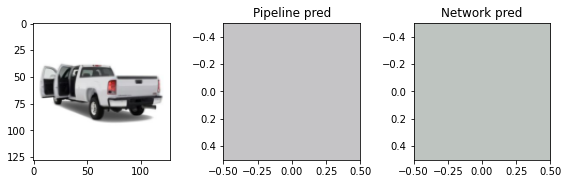

In [390]:
id = 5
rows = 1
cols = 3
axes=[]
fig=plt.figure(figsize = (8,8))

pic = [imgs[mask][id].permute(1,2,0),labels[mask][id].reshape(1,1,3),out.detach()[mask][id].reshape(1,1,3)]

for a in range(rows*cols):
    b = pic[a]
    title = ''
    if a == 1:
        title = 'Pipeline pred'
    elif a == 2:
        title = 'Network pred'
    axes.append( fig.add_subplot(rows, cols, a+1, title=  title) )
    plt.imshow(b)
fig.tight_layout()    
plt.show()